In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from peel_by_motif import *
import random, collections
from datetime import datetime
import pandas as pd
import itertools, os
from utils import *
import math
from networkx.drawing.nx_agraph import graphviz_layout
plt.rcParams.update({'font.size': 14})

In [ ]:
def kl_divergence(p, q):
    return sum(p[i] * math.log(p[i]/q[i],2) for i in range(len(p)) if p[i]>0)

def node_chisquare(edgelist, node_num, dist, adjust_idx=1, directed='both', diff_func='chi'):
    '''
    edgelist: list of edges. Each item is a tuple contains (node_from, node_to, edge_weight) representing a weighted edge.
    node_num: number of nodes.
    dist: list of float sum to 1, describe the distribution used to calculate the chi square statistic. 
    '''
    node_induced_dist = [[] for i in range(node_num)]
    node_chis = []
    for edge in edgelist:
        if directed=='both' or directed=='out':
            node_induced_dist[edge[0]].append(edge[2])
        if directed=='both' or directed=='in':
            node_induced_dist[edge[1]].append(edge[2])
#             G[node][neighbor]['weight']
    for node_dist in node_induced_dist:
        count_dist = count_occ(node_dist, len(dist), adjust_idx)
#        get the chi square statistic, the higher it is, more abnormal the node is
        if diff_func=='chi':
            node_chis.append(chisquare(count_dist, sum(count_dist)*np.array(dist))[0])
        elif diff_func=='kl':
            node_chis.append(kl_divergence(np.array(count_dist)/sum(count_dist), np.array(dist)))
    return node_chis

## Preprocessing steps. Note the nx.Graph is constructed only for further graph analysis but not required for computing $\chi^2$.

In [3]:


benford = []
xs = [i for i in range(1,10)]
for i in range(9):
    benford.append(math.log10(1+1/(i+1)))

In [4]:
G = nx.DiGraph()
f = open('data/eth_token_jan2019.csv', 'r')
edgelist = []
node_map = {}
line = f.readline()
line = f.readline()
e_count = 0
n_idx = 0
while line:
    tmp = line.split(',')
    line = f.readline()
    date = tmp[-2].strip()
    money = tmp[-1].strip()
    if len(money)<=18:
        continue
    if tmp[1]==tmp[2]:
        continue
    if tmp[1] not in node_map:
        node_map[tmp[1]] = n_idx
        n_idx += 1
    if tmp[2] not in node_map:
        node_map[tmp[2]] = n_idx
        n_idx += 1
    money = int(money[:-18])
    edgelist.append((node_map[tmp[1]],node_map[tmp[2]],get_start_digit(money), money, date))

    if node_map[tmp[1]] in G and node_map[tmp[2]] in G[node_map[tmp[1]]]:
        G[node_map[tmp[1]]][node_map[tmp[2]]]['weight'] += money
    else:
        G.add_edge(node_map[tmp[1]], node_map[tmp[2]], weight=money)
#     amount_list.append(float(money))
    e_count += 1
    
#     break
print('amount of transactions with >1 volume', e_count, 'by', date)

amount of transactions with >1 volume 6128061 by 2019-01-07


In [5]:
G.number_of_nodes(), G.number_of_edges()

(2199347, 3331594)

## empirical distribution and how it fits Benford distribution.

0.034444940542604684


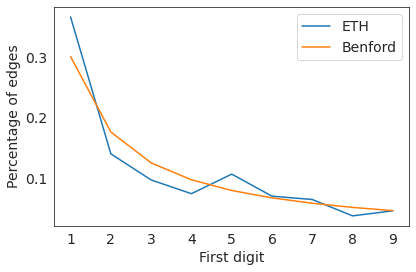

In [107]:
x = [e[2] for e in edgelist]
x = collections.Counter(x)
num_occ = np.array([x[k] for k in range(1,10)])/sum([x[k] for k in range(1,10)])
print(kl_divergence(num_occ,benford))
plt.plot([str(i) for i in range(1,10)], num_occ, label='ETH')
plt.plot([str(i) for i in range(1,10)], benford, label='Benford')
plt.xlabel('First digit')
plt.ylabel('Percentage of edges')
plt.legend()
plt.tight_layout()
plt.savefig('eth_results/figs/2019_dist.png')
plt.show()

In [108]:
obs = [x[k] for k in range(1,10)]
times = sum(obs)
c3,p3 = stats.chisquare(obs, np.array(benford)*times)
lr = -2 * sum([obs[i]*math.log(benford[i]/(obs[i]/times)) for i in range(9) if obs[i]!=0])
c3, c3/G.number_of_nodes(), c3/G.number_of_edges()

(291722.42058599304, 0.13264047036961107, 0.08890688309048911)

### Calculate node $\chi^2$, i.e. s(u). In practice we can try other difference metrics such as KL divergence, etc.

In [21]:
node_chisquares = node_chisquare(edgelist, G.number_of_nodes(), benford, adjust_idx=1, diff_func='kl')

In [8]:

uG = G.to_undirected()
uG.remove_edges_from(nx.selfloop_edges(uG))
uG.number_of_nodes(), uG.number_of_edges()

(2199347, 3281213)

### Output new graph with reweighted edges.

In [10]:
f_out = open('data/eth2019_weighted_sqrt.edgelist','w')
s = 0
f_out.write(str(uG.number_of_nodes())+' '+str(uG.number_of_edges())+'\n')
for edge in uG.edges():
    f_out.write(str(edge[0])+' '+str(edge[1])+' '+str(int(100*math.sqrt(node_chisquares[edge[0]]*node_chisquares[edge[1]])))+'\n')
f_out.close()

## Please run the C++ code in DSD_cpp folder to find top 5 dense(AntiBenford) subgraphs before running the following cells.

## Result analysis (top 5 Antibenford subgraph)

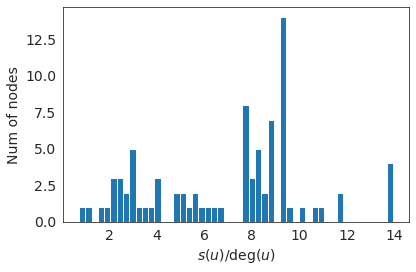

131818.6973288083 0.0 65256.21627559107 0.0 1588.1770762507026 213.9277108433735


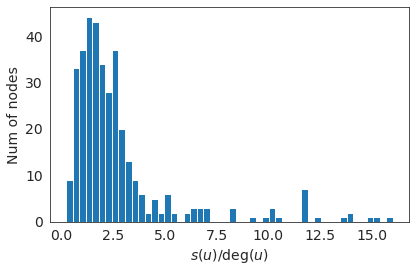

3963.364849676117 0.0 3726.0356889323084 0.0 10.888364971637685 15.486263736263735


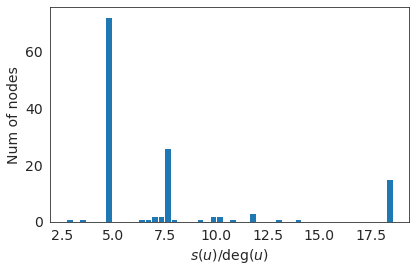

1205.2998831606494 0.0 1158.1760569877456 0.0 9.062405136546236 4.7669172932330826


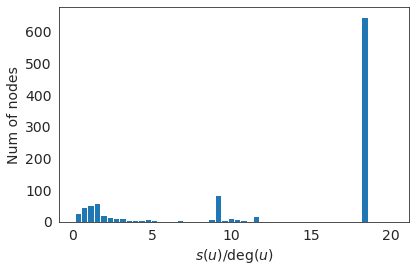

10677.861681532475 0.0 9081.461093648011 0.0 9.58515411268624 14.153500897666069


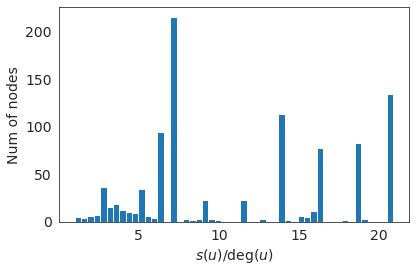

9372.7957577928 0.0 6471.178600451431 0.0 9.496246968381762 3.9604863221884496


In [122]:
# check statistical significance
from scipy import stats

dsd_output_prefix = 'eth_results/eth_sqrt.txt'

for idx in range(5):
    f = open(dsd_output_prefix+str(idx),'r')
    line = f.readline()
    res = []
    while line:
        res.append(int(line.strip()))
        line = f.readline()

    interest = G.subgraph(res)
    t = nx.get_edge_attributes(interest,'weight')
    el = []
    interest = nx.convert_node_labels_to_integers(interest)
    for e in interest.edges():
        for w in interest[e[0]][e[1]]['weight']:
            el.append([e[0],e[1],w])
    node_chisquares1 = node_chisquare(el, interest.number_of_nodes(), benford, adjust_idx=1, diff_func='chi')
    avg_chi = []
    et = 0
    for i in range(interest.number_of_nodes()):
        tmp_deg = sum([len(interest[i][j]['weight']) for j in interest[i]])
        et += tmp_deg
#         if tmp_deg<5:
#             continue
        avg_chi.append(node_chisquares1[i]/tmp_deg)
    plt.hist(avg_chi,bins=50)
    plt.xlabel(r'$s(u)/\deg(u)$')
    plt.ylabel('Num of nodes')
    plt.tight_layout()
    plt.savefig('eth_results/figs/hist_token19_'+str(idx)+'.png')
    plt.show()
    
    res = []
    for j in t:
        res += t[j]
    x = collections.Counter(res)
    obs = []
    for i in range(1,10):
        if i not in x:
            obs.append(0)
        else:
            obs.append(x[i])
    times = sum(obs)
    c3,p3 = stats.chisquare(obs, np.array(benford)*times)
    chi = sum([(obs[i]-benford[i]*times)**2/(benford[i]*times) for i in range(9)])
    lr = -2 * sum([obs[i]*math.log(benford[i]/(obs[i]/times)) for i in range(9) if obs[i]!=0])
    pval1 = 1 - stats.chi2.cdf(chi, 8)
    pval2 = 1 - stats.chi2.cdf(lr, 8)
    print(chi, pval1, lr, pval2, c3/interest.number_of_nodes(), et/2/interest.number_of_nodes())

## We only give partial code for empirical distribution visualization. The rest graph visualization and anomalous behavior analysis are done on Kaggle's notebook as the full data is only available from there.

In [26]:
f = open(dsd_output_prefix + '0','r')
line = f.readline()
res = []
while line:
    res.append(int(line.strip()))
    line = f.readline()


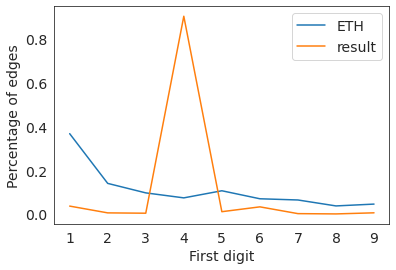

In [27]:
agg = []
for e in edgelist:
    if e[0] in res and e[1] in res:
        agg.append(e[2])

x = collections.Counter(agg)
cur_num_occ = np.array([x[k] for k in range(1,10)])/sum([x[k] for k in range(1,10)])
plt.plot([str(i) for i in range(1,10)], num_occ, label='ETH')
plt.plot([str(i) for i in range(1,10)], cur_num_occ, label='result')
plt.xlabel('First digit')
plt.ylabel('Percentage of edges')
plt.legend()
plt.show()

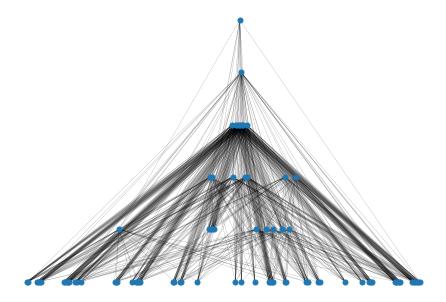

In [14]:

pos=graphviz_layout(G.subgraph(res), prog='dot')
nx.draw(G.subgraph(res), pos, with_labels=False,width=0.1, arrows=False, node_size=25)
            

In [75]:
f = open(dsd_output_prefix + '1','r')
line = f.readline()
res = []
while line:
    res.append(int(line.strip()))
    line = f.readline()


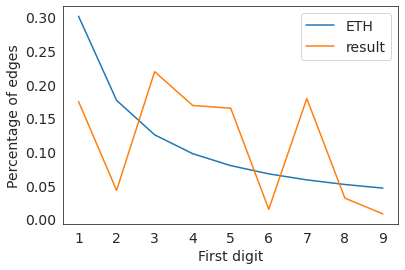

In [59]:
agg = []
for e in edgelist:
    if e[0] in res and e[1] in res:
        agg.append(e[2])

x = collections.Counter(agg)
cur_num_occ = np.array([x[k] for k in range(1,10)])/sum([x[k] for k in range(1,10)])
plt.plot([str(i) for i in range(1,10)], benford, label='ETH')
plt.plot([str(i) for i in range(1,10)], cur_num_occ, label='result')
plt.xlabel('First digit')
plt.ylabel('Percentage of edges')
plt.legend()
plt.show()

In [76]:
small_cc = min(nx.connected_components(G.subgraph(res)), key=len)
interest = G.subgraph(small_cc)

In [77]:
t = nx.get_edge_attributes(interest,'weight')
res = []
for j in t:
    res += t[j]
x = collections.Counter(res)

In [68]:
obs = []
for i in range(1,10):
    if i not in x:
        obs.append(0)
    else:
        obs.append(x[i])

In [ ]:

pos=graphviz_layout(interest, prog='dot')
col = []
for i in interest.nodes():
    if i==665:
        col.append('r')
        continue
    if remain[i]<0:
        col.append('y')
    else:
        col.append('b')
    

nx.draw(interest, pos, with_labels=False,width=0.1, arrows=True, node_size=25, node_color=col)
            

In [64]:
pinterest = nx.DiGraph(interest)
mid = []
for n in pinterest[665]:
    if interest.in_degree[n]==1:
        mid.append(n)

In [68]:
pinterest.in_degree(weight='weight')[665], pinterest.out_degree(weight='weight')[665]

(451596, 357034)

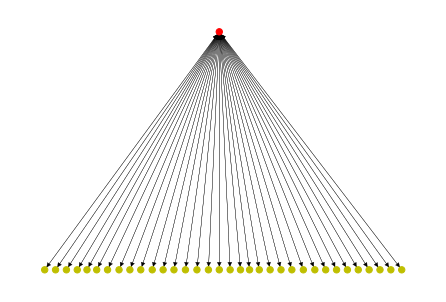

In [52]:
upper = pinterest.subgraph(mid+[665])
pos=graphviz_layout(upper, prog='dot')
pos[45314]=(3361.1*2-3257.1, 18.0)
col = []
for i in upper.nodes():
    if i==665:
        col.append('r')
    else:
        col.append('y')
nx.draw(upper, pos, with_labels=False,width=0.3, arrows=True, node_size=40, node_color=col)
plt.savefig('eth_results/figs/2019_upstruc.png')
plt.show()

In [36]:
remain = {}
for n in pinterest.nodes():
    s = 0
    t = 0
    for i in pinterest[n]:
        s += pinterest[n][i]['weight']
    for i in pinterest.predecessors(n):
        t += pinterest[i][n]['weight']
    remain[n] = s-t

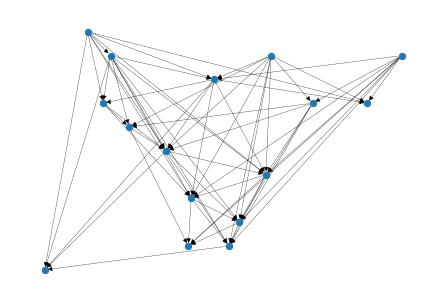

In [60]:
pinterest.remove_node(665)
pinterest.remove_nodes_from(mid)
pos=graphviz_layout(pinterest, prog='dot')

nx.draw(pinterest, pos, with_labels=False,width=0.3, arrows=True, node_size=40)
plt.savefig('eth_results/figs/2019_botstruc.png')
plt.show()
# for n in mid:
#     for i in pinterest[n]:
#         if pinterest.out_degree[i]>1 and i!='665':
#             print(pinterest[i])

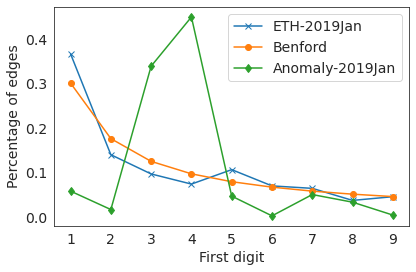

In [94]:
agg = []
for e in edgelist:
    if e[0] in small_cc and e[1] in small_cc:
        agg.append(e[2])

x = collections.Counter(agg)
cur_num_occ = np.array([x[k] for k in range(1,10)])/sum([x[k] for k in range(1,10)])
plt.plot([str(i) for i in range(1,10)], num_occ, label='ETH-2019Jan', marker='x')
plt.plot([str(i) for i in range(1,10)], benford, label='Benford', marker='o')
plt.plot([str(i) for i in range(1,10)], cur_num_occ, label='Anomaly-2019Jan', marker='d')
plt.xlabel('First digit')
plt.ylabel('Percentage of edges')
plt.legend()
plt.tight_layout()
plt.savefig('eth_results/figs/2019_violate_dist.png')
# plt.savefig(f_path + 'distribution_compare.eps', format='eps')
# plt.savefig(f_path + 'distribution_compare.pdf')
plt.show()

In [31]:
get_key(node_map, [665])

['0x146bde3d01c9a16c7a5bf3809bbc2cbf338d198d']